# **Mapping Ocean Observation Platforms in the Souther Ocean** #

*Where are the sentinels of the Southern Ocean, and what are they revealing to us?*

**Purpose**

This notebook provides tools to explore, filter and visualize ocean observation platforms using metadata from the OCEAN ICE ERDDAP server.

Users can:

*  **Select specific datasets or view all available platforms.**
*  **Filter platforms by temporal coverage (start and end years).**
*  **Analyze the number of active platforms per year.**
*  **Map the geospatial footprints and centroids of platforms on an Antarctic base map.**

The goal is to provide a clear overview of when and where observational platforms have been active, supporting both data discovery and scientific analysis in polar and global ocean studies.

**Data sources**

The notebook uses the PLATFORMS_METADATA table from the OCEAN ICE ERDDAP server.

This metadata collection provides:

*  Dataset identifiers (e.g., ARGO floats, moorings, CTDs).
*  Temporal coverage (`time_coverage_start` and `time_coverage_end`) for each dataset.
*  Geospatial extent (`latitude_min/max`, `longitude_min/max`).
*  Platform information (name, type and related metadata).

By combining the time and spatial metadata, the notebook reconstructs each platform’s active period and operating area, enabling tracking of observational efforts through time and across regions.

**Instructions to use this Notebook**

Run each code cell by clicking the **Play button** (▶️) on the left side of each grey code block. This will execute the code in order and allow all features to work properly.

**Explaining the code**

**1.   Install required libraries**

This section sets up the notebook for map-based analysis and plotting. Libraries enable drawing maps, overlaying geometric shapes (bounding boxes) and building interactive controls:

* **Geospatial and mapping:** shapely.geometry.box, geopandas, cartopy.crs, cartopy.feature, matplotlib.pyplot.
* **Interactive widgets:** ipywidgets, IPython.display.display.
* **Data Handling:** pandas, requests, io.

In [ ]:
# @title
!pip install cartopy
from shapely.geometry import box
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import requests
import io

**2. Load and inspect platform metadata from ERDDAP**

Retrieve the metadata of all available ocean platforms, prepare it for queries and extract key information such as dataset names and temporal coverage.

In [ ]:
# @title
PLATFORMS_META_URL = 'https://er1.s4oceanice.eu/erddap/tabledap/PLATFORMS_METADATA.csv'

platforms_meta_resp = requests.get(PLATFORMS_META_URL)
platforms_meta_resp.raise_for_status()
platforms_meta_df = pd.read_csv(io.StringIO(platforms_meta_resp.text))
platforms_meta_df = platforms_meta_df[1:]

all_datasets = platforms_meta_df['dataset'].drop_duplicates().reset_index(drop=True)
try:
  time_range = pd.to_datetime(platforms_meta_df['time_coverage_start']).min().year, pd.to_datetime(platforms_meta_df['time_coverage_end']).max().year
except Exception as e:
  print("Error extracting time_coverage_start and time_coverage_end, using default values (1960, 2025)")
  time_range = (1960, 2025)

platforms_meta_df

,platform,dataset,time_coverage_start,time_coverage_end,geospatial_latitude_min,geospatial_latitude_max,geospatial_longitude_min,geospatial_longitude_max
1,AM83_CoreB,AAD_ASPeCt-Bio_historical,1983-11-15T00:00:00Z,1983-11-15T00:00:00Z,-62.1800,-62.1800,-36.5900,-36.5900
2,AM83_CoreC,AAD_ASPeCt-Bio_historical,1983-11-15T00:00:00Z,1983-11-15T00:00:00Z,-62.1800,-62.1800,-36.5900,-36.5900
3,AM83_CoreF,AAD_ASPeCt-Bio_historical,1983-11-16T00:00:00Z,1983-11-16T00:00:00Z,-61.5900,-61.5900,-36.2700,-36.2700
4,AM83_CoreG,AAD_ASPeCt-Bio_historical,1983-11-16T00:00:00Z,1983-11-16T00:00:00Z,-61.5900,-61.5900,-36.2700,-36.2700
5,AM83_CoreH,AAD_ASPeCt-Bio_historical,1983-11-16T00:00:00Z,1983-11-16T00:00:00Z,-61.5900,-61.5900,-36.2700,-36.2700
...,...,...,...,...,...,...,...,...
18210,990004,NPI_Iceberg_database,2000-02-23T10:00:00Z,2000-03-17T03:15:00Z,-68.4833,-62.7333,-69.6333,-60.1500
18211,990005,NPI_Iceberg_database,1999-11-26T12:00:00Z,2000-04-03T12:00:00Z,-77.2000,-52.0000,-66.0000,-5.0000
18212,990006,NPI_Iceberg_database,2000-01-14T06:00:00Z,2000-04-08T06:00:00Z,-65.6167,-39.7000,-69.3333,-29.0000
18213,990007,NPI_Iceberg_database,2000-01-12T18:00:00Z,2000-03-07T06:00:00Z,-70.4333,-52.1167,-18.7000,25.4167


**3. Interactive filters: dataset selection and time range**

Widgets allow users to filter metadata by dataset and time window. Expand each platform's coverage into per-year records to quantify annual platform activity.

In [ ]:
# @title
dataset_dropdown = widgets.Dropdown(
    options=["All datasets"] + all_datasets.tolist(),
    value="All datasets",
    description="Dataset:"
)

start_year_input = widgets.IntText(
    value=time_range[0],
    description="Start year:"
)
end_year_input = widgets.IntText(
    value=time_range[1],
    description="End year:"
)

display(dataset_dropdown, start_year_input, end_year_input)

Dropdown(description='Dataset:', options=('All datasets', 'AAD_ASPeCt-Bio_historical', 'AADC_sea_ice_measureme…

IntText(value=1960, description='Start year:')

IntText(value=2025, description='End year:')

**4. Filter platforms & plot “Active Platforms per Year”**

Subset platform metadata by the chosen dataset and time window. Expand each platform’s coverage into per-year records to quantify annual platform activity.

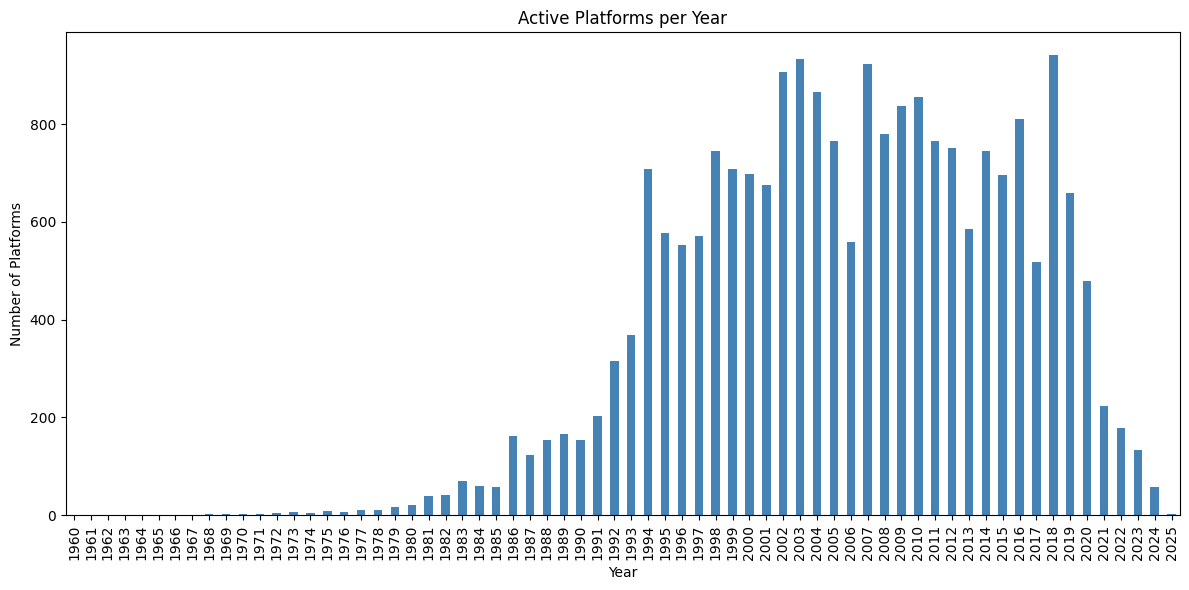

In [ ]:
# @title
df_times = platforms_meta_df.copy()

if df_times["time_coverage_start"].dtype == "object":
    df_times["time_coverage_start"] = pd.to_datetime(df_times["time_coverage_start"])
    df_times["time_coverage_end"] = pd.to_datetime(df_times["time_coverage_end"])
    df_times = df_times.dropna(subset=["time_coverage_start", "time_coverage_end"])

start_year = start_year_input.value
end_year = end_year_input.value
if start_year < time_range[0] or start_year > time_range[1]:
    start_year = time_range[0]
if end_year < time_range[0] or end_year > time_range[1]:
    end_year = time_range[1]

if dataset_dropdown.value != "All datasets":
    df_times = df_times[df_times["dataset"] == dataset_dropdown.value]

mask = (
    (df_times["time_coverage_start"].dt.year <= end_year) &
    (df_times["time_coverage_end"].dt.year >= start_year)
)
df_times = df_times[mask]

records = []
for _, row in df_times.iterrows():
    s = max(row["time_coverage_start"].year, start_year)
    e = min(row["time_coverage_end"].year, end_year)
    for year in range(s, e + 1):
        records.append({"year": year, "platform": row["platform"]})

year_df = pd.DataFrame(records)

counts = year_df.groupby("year")["platform"].nunique()
plt.figure(figsize=(12, 6))
counts.reindex(range(start_year, end_year + 1), fill_value=0).plot(
    kind="bar", color="steelblue"
)
plt.xlabel("Year")
plt.ylabel("Number of Platforms")
plt.title("Active Platforms per Year")
plt.tight_layout()
plt.show()

**5. Filter platforms, compute footprint centroids, and map on Antarctica**

This section:

* Filters platform metadata by dataset and year range.
* Builds platform’s spatial footprint using its min/max lat–lon as a Shapely box.
* Converts to a GeoDataFrame (EPSG:4326 → Antarctic polar stereographic EPSG:3031).
* Computes centroids of each platform footprint.
* Plots centroids on a South Polar map with Cartopy, color-coded by dataset with a legend.

/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_ocean.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


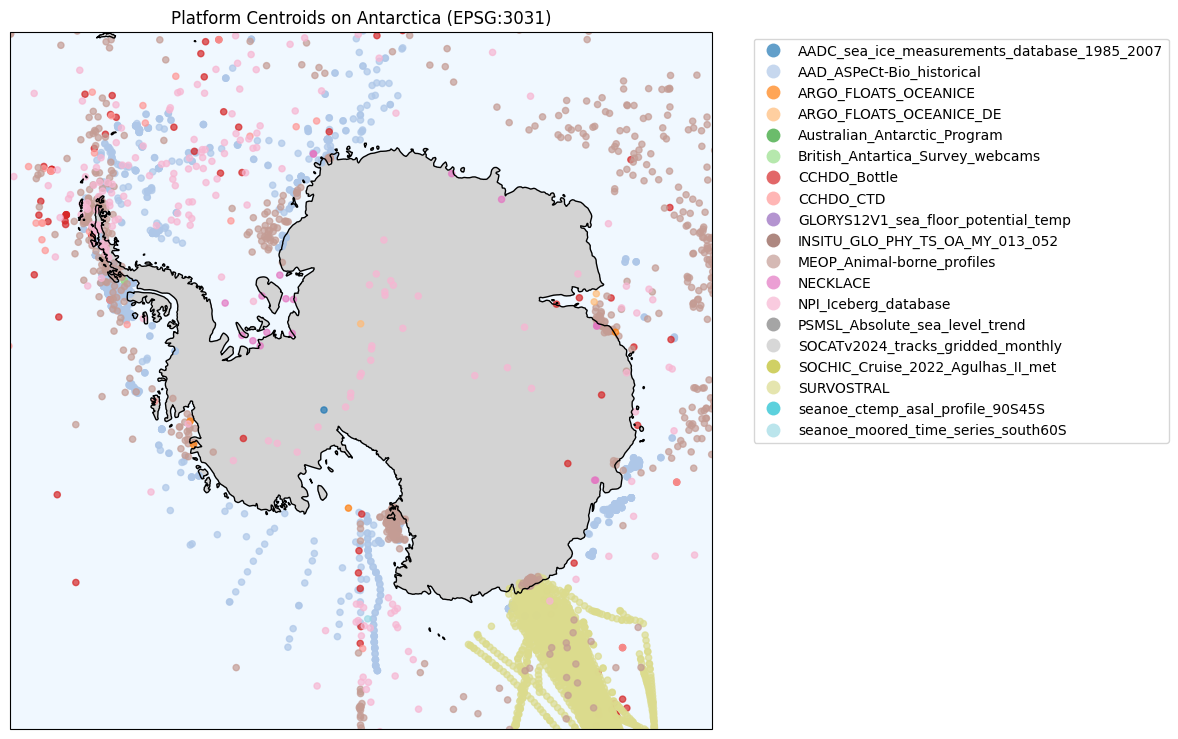

In [ ]:
# @title
df_centroids = platforms_meta_df.copy()

if df_centroids["time_coverage_start"].dtype == "object":
    df_centroids["time_coverage_start"] = pd.to_datetime(df_centroids["time_coverage_start"])
    df_centroids["time_coverage_end"] = pd.to_datetime(df_centroids["time_coverage_end"])
    df_centroids = df_centroids.dropna(subset=["time_coverage_start", "time_coverage_end"])

start_year = start_year_input.value
end_year = end_year_input.value
if start_year < time_range[0] or start_year > time_range[1]:
    start_year = time_range[0]
if end_year < time_range[0] or end_year > time_range[1]:
    end_year = time_range[1]

if dataset_dropdown.value != "All datasets":
    df_centroids = df_centroids[df_centroids["dataset"] == dataset_dropdown.value]

mask = (
    (df_centroids["time_coverage_start"].dt.year <= end_year) &
    (df_centroids["time_coverage_end"].dt.year >= start_year)
)
df_centroids = df_centroids[mask]


df_centroids = df_centroids.dropna(subset=[
    "geospatial_latitude_min", "geospatial_latitude_max",
    "geospatial_longitude_min", "geospatial_longitude_max"
]).copy()

df_centroids["geometry"] = df_centroids.apply(
    lambda row: box(
        row["geospatial_longitude_min"],
        row["geospatial_latitude_min"],
        row["geospatial_longitude_max"],
        row["geospatial_latitude_max"]
    ),
    axis=1
)

gdf = gpd.GeoDataFrame(df_centroids, geometry="geometry", crs="EPSG:4326")

gdf_proj = gdf.to_crs("EPSG:3031")
gdf_proj["centroid"] = gdf_proj.geometry.centroid

fig = plt.figure(figsize=(12, 12))
ax = plt.axes(projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())

ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='aliceblue')
ax.add_feature(cfeature.COASTLINE)

gdf_proj.set_geometry("centroid").plot(
    ax=ax,
    column="dataset",
    cmap="tab20",
    alpha=0.7,
    markersize=20,
    legend=True,
    legend_kwds={'bbox_to_anchor': (1.05, 1), 'loc': 'upper left'}
)

ax.set_title("Platform Centroids on Antarctica (EPSG:3031)")
plt.tight_layout()
plt.show()

This work has received funding from the European Union Horizon Europe project Ocean-Cryosphere Exchanges in ANtarctica: Impacts on Climate and the Earth System (OCEAN ICE) under grant agreement No. 101060452 (https://doi.org/10.3030/101060452). UK partners are funded by UK Research and Innovation (UKRI) under the UK government’s Horizon Europe funding guarantee. 

<center>
  <div style="display: flex; justify-content: center; align-items: flex-start; gap: 20px;">
    <img src="https://ocean-ice.eu/wp-content/uploads/2025/02/TO-USE-RGB-for-digital-materials-V.png" height="140" style="margin-top: 50px;"/>
    <img src="https://ocean-ice.eu/wp-content/uploads/2025/02/UKRI-logo-1.png" height="120"/>
    <img src="https://ocean-ice.eu/wp-content/uploads/2023/06/logo-polar-cluster-2.png" height="120"/>
  </div>
</center>